# Book Data EDA

In this notebook I will do EDA on data from the [book crossing dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The dataset features info about books rated on https://www.bookcrossing.com/ and is broken into three tables: Books, Users and Ratings. Each table is related by the ISBN number for each book. 

In [79]:
# data munging
import numpy as np
import pandas as pd
import sqlite3

# eda/viz
import matplotlib.pyplot as plt
import seaborn as sns

## Importing book data

In [68]:
!ls data/BX-CSV-Dump

BX-Book-Ratings.csv BX-Books.csv        BX-Users.csv


In [217]:
books = pd.read_csv('data/BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv('data/BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('data/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/Users/max/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/i

## Exploration and cleaning
### Books Data

In [218]:
print(books.shape)
books.head(3)

(271360, 8)


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


Three entries have entries that are off by a column. Dropping these three records. 

In [219]:
# filtering for non-ints in yearOfPublication

books.drop(books[pd.to_numeric(books.yearOfPublication, errors='coerce').isnull()].index, inplace=True)

In [220]:
# changing all to int type and finding min/max
books.yearOfPublication = books.yearOfPublication.astype(int)

print(books.yearOfPublication.min())
print(books.yearOfPublication.max())

0
2050


Many books are published in the future or have 0 as their pub date. Time to remove those. This data was scraped in 2004 so nothing should have been published after that year. 

In [221]:
books.drop(books[books.yearOfPublication == 0].index, inplace=True)
books.drop(books[books.yearOfPublication > 2004].index, inplace=True)

print(books.yearOfPublication.min())
print(books.yearOfPublication.max())

1376
2004


In [223]:
books[books.yearOfPublication < 1900]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
171817,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806,Reprint Services Corp,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...,http://images.amazon.com/images/P/0781228956.0...
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...
245607,0781268001,"Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...",Silas Weir Mitchell,1897,Reprint Services Corp,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...,http://images.amazon.com/images/P/0781268001.0...
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...


The book published in 1376 and 1378 and 1806 appear to have been a mistake, so I will remove that record. This will  make the publishing year distribution a bit more normal (althought still quite skewed).

In [225]:
books.drop(books[books.yearOfPublication <1896].index, inplace=True)

print(books.yearOfPublication.min())

1897


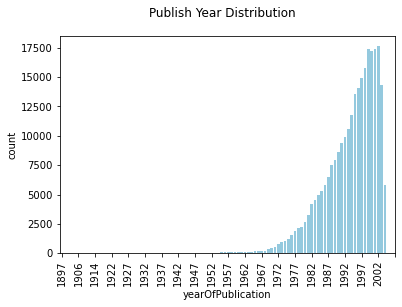

In [255]:
sns.countplot(books.yearOfPublication, color='skyblue')
plt.xticks([year for year in range(0, 105, 5)], rotation=90)
plt.suptitle('Publish Year Distribution');

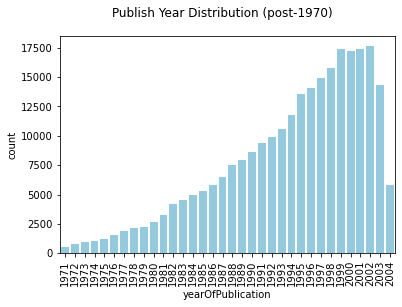

In [274]:
# detail of just recent books 

sns.countplot(books[books.yearOfPublication > 1970].yearOfPublication, color='skyblue')
plt.xticks(rotation=90)
plt.suptitle('Publish Year Distribution (post-1970)');

### Users Data

In [77]:
print(users.shape)
users.head(3)

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [97]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userID    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Missing age data for ~100k users. Consider whether or not age will matter for collaborative recommendation. 

Text(0.5, 0.98, 'User Age Distribution')

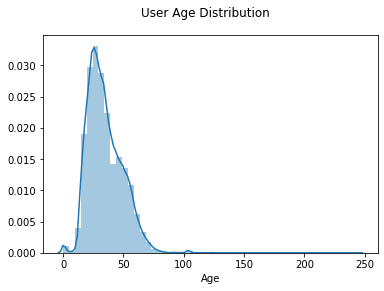

In [98]:
sns.distplot(users.Age)
plt.suptitle('User Age Distribution (Raw)')

Plotting age distribution shows there are some incorrectly entered user ages. Will have to remove low and high ages when cleaning. 

In [258]:
# users under age 10

users[users.Age < 15].groupby('Age').count()

,userID,Location
Age,,
0.0,416,416
1.0,288,288
2.0,105,105
3.0,45,45
4.0,28,28
5.0,26,26
6.0,18,18
7.0,27,27
8.0,54,54


In [262]:
# users over age 100
users[users.Age > 99].groupby('Age').count()

,userID,Location
Age,,
100.0,7,7
101.0,7,7
102.0,3,3
103.0,56,56
104.0,192,192
...,...,...
230.0,1,1
231.0,1,1
237.0,1,1


I'll drop ages under 13, since that's where there appears to be a dramatic drop off in reviews, and that also passes a sanity test of how old the youngest readers are likely to be. Since ages trickle in consistently over all but go all the way to over 200, I will cap age at 99 because there a spike in reviews between 100-105, and I believe that to be an erorr, considering it is fairly unlikely there is a group of very tech savvy centurions reviewing books online in the early 2000s. 

In [276]:
users.drop(users[users.Age > 99].index, inplace=True)
users.drop(users[users.Age < 13].index, inplace=True)

Text(0.5, 0.98, 'User Age Distribution (Clean)')

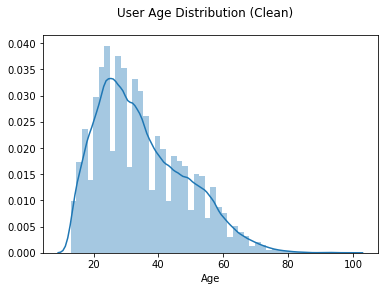

In [277]:
sns.distplot(users.Age)
plt.suptitle('User Age Distribution (Clean)')

### Ratings Data

In [80]:
print(ratings.shape)
ratings.head(3)

(1149780, 3)


,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [112]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [282]:
ratings.bookRating.describe()

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: bookRating, dtype: float64

In [283]:
ratings[ratings.bookRating > 0].bookRating.describe()

count    433671.000000
mean          7.601066
std           1.843798
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: bookRating, dtype: float64

No nulls for all books that have been rated.

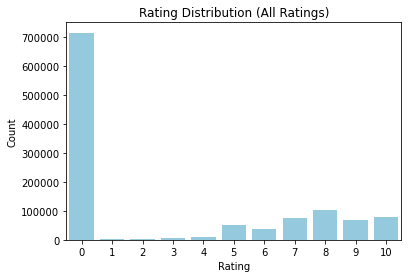

In [273]:
sns.countplot(ratings.bookRating, color='skyblue')
plt.title('Rating Distribution (All Ratings)')
plt.xlabel('Rating')
plt.ylabel('Count');

0 on this scale means that the book was not rated. It's clear from this viz that the vast majority of books weren't rated. (from the [note from [data source](http://www2.informatik.uni-freiburg.de/~cziegler/BX/): "Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0."

In [268]:
print('"0" Ratings:   ', ratings[ratings.bookRating == 0].bookRating.count(), '>>>', round(ratings[ratings.bookRating == 0].bookRating.count() / ratings.bookRating.count() * 100), '%')
print('"1-10" Ragints:', ratings[ratings.bookRating > 0].bookRating.count(), '>>>', round(ratings[ratings.bookRating > 0].bookRating.count() / ratings.bookRating.count() * 100), '%')

"0" Ratings:    716109 >>> 62 %
"1-10" Ragints: 433671 >>> 38 %


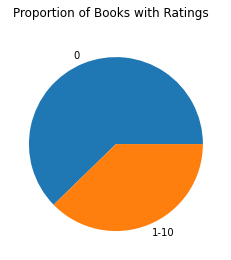

In [269]:
rating_proportion_list = [ratings[ratings.bookRating == 0].bookRating.count(), ratings[ratings.bookRating > 0].bookRating.count()]

plt.pie(rating_proportion_list, labels=['0', '1-10'])
plt.suptitle('Proportion of Books with Ratings');

Text(0, 0.5, 'Count')

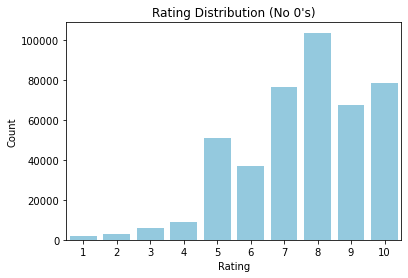

In [271]:
sns.countplot(ratings.bookRating[ratings.bookRating > 0], color='skyblue')
plt.title('Rating Distribution (No 0\'s)')
plt.xlabel('Rating')
plt.ylabel('Count')

In [300]:
ratings.sort_values(by='userID')

,userID,ISBN,bookRating
9561,2,0195153448,0
9562,7,034542252,0
9572,8,0771025661,0
9580,8,1881320189,7
9579,8,1575663937,6
...,...,...,...
9560,278854,0553579606,8
9554,278854,0375703063,7
9553,278854,0316184152,7
9555,278854,042516098X,7


# To do

* dig deeper into what 0 ratings mean
* engineer features
    * user level
        * number of users
        * reviews per user 
            * avg, >1, >2, >10, etc
        * avg user rating given

    * book level
        * unrated books
        * avg book rating
        * reviews per book
